In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy import interpolate
import networkx as nx

import pandas as pd
from sklearn.cluster import KMeans

import landscape as ld
from networkx.algorithms import approximation as apx

# utils

In [3]:
def make_graph(Nx0, L, alpha, points):
    
    #compute landscape function
    fLand = ld.find_landscape(Nx0 = Nx0, L = L, A0 = 5000, points = points)
    
    # create square grid graph
    G = nx.grid_2d_graph(range(1,int(L)), range(1,int(L))) 

    print( 'number of original edges {}'.format(len(G.edges))) 
    
    # delete edges where the landscape function > alpha 
    for e in G.edges:
        x, y = 0.5*(np.array(e[0]) + np.array(e[1]))
        if fLand(x,y) > alpha:
            G.remove_edge(e[0],e[1])
            
    # delete nodes with degree 1
    ends = [ x[0] for x in G.degree() if x[1] <= 1]
    G.remove_nodes_from(ends)
            
    print( 'number of final edges {}'.format(len(G.edges)))
            
    return G

In [4]:
def get_pos(g):
    return dict( (n, n) for n in g.nodes() )

In [5]:
def make_graph_plot(Nx0, L, alpha, points):
    #make graph 
    G = make_graph(Nx0, L, alpha, points)
    pos = dict( (n, n) for n in G.nodes() )
    
    # get points for scatter plot
    xpoints = [point[0] for point in points]
    ypoints = [point[1] for point in points]
    
    # plotology 
    fig, ax = plt.subplots(figsize=(4,4));

    plt.xlim(0, L)
    plt.ylim(0, L)

    nx.draw_networkx_edges(G, pos, ax = ax, with_labels = False)
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

    # add scatter plot
    plt.scatter(xpoints, ypoints)
    plt.show()

In [6]:
def make_naive_steiner_plot(G, L, points):
    
    # approximate steiner tree
    G_st = apx.steinertree.steiner_tree(G, points, weight='length') 
    print('The number of edges of the Steiner tree is '+ str(G_st.number_of_edges()))
    
    xpoints = [point[0] for point in points]
    ypoints = [point[1] for point in points]

    fig, ax = plt.subplots(figsize=(6,6)); plt.xlim(0, L); plt.ylim(0, L);
    
    nx.draw(G, pos = get_pos(G), node_size = 0)
    nx.draw(G_st, pos = get_pos(G_st), node_size = 0, edge_color = 'r', width = 2.5)
    plt.scatter(xpoints, ypoints);

In [7]:
def make_improved_steiner_plot(G, L, alpha, points):
    
    # cut edges with landscape function. This gives a series of non-connected graphs. Pick largest and compute
    # Steiner tree
    G_ld = make_graph(40, L, alpha, points)
    
    # all connected components of G after cutting edges
    graphs = [G_ld.subgraph(c).copy() for c in nx.connected_components(G_ld)]

    fig, ax = plt.subplots(figsize=(6,6)); plt.xlim(0, L); plt.ylim(0, L);
    nx.draw(G_ld, pos = get_pos(G_ld), node_size = 0)
    
    # compute steiner for smaller G
    count_edges = 0
    for graph in graphs:
        G_ld_st = apx.steinertree.steiner_tree(graph, points, weight='length') 
        count_edges += G_ld_st.number_of_edges()
        
        nx.draw(G_ld_st, pos = get_pos(G_ld_st), node_size = 0, edge_color = 'r', width = 2.5)
    
    print('The total number of edges of the Steiner trees is '+ str(count_edges))
    
    xpoints = [point[0] for point in points]
    ypoints = [point[1] for point in points]
    
    plt.scatter(xpoints, ypoints);

# Example 1:
Precooked example, fixed points

In [8]:
# points we want to cluster and join
points = [(1, 1), (2, 2), (3, 4), (5, 1), (5, 4), (8, 2), (7, 8), (6,  6), (2,8), (4,3) ]
#points = [[1, 1], [2, 2], [3, 4], [5, 1], [5, 4], [8, 2], [7, 8], [6,  6] , [2, 8], [4,3] ]

number of original edges 144
number of final edges 52


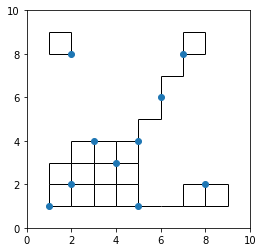

In [9]:
make_graph_plot(Nx0 = 40, L = 10, alpha = 0.8, points = points)

# Example 2
Points selected at random. Try varying alpha for different results. Higher alpha includes more edges

In [24]:
points2 = np.random.randint(18, size=(40, 2)) + 1

number of original edges 684
number of final edges 146


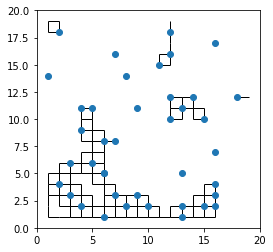

In [25]:
make_graph_plot(Nx0 = 40, L = 20, alpha = 0.8, points = points2)

## K-means clustering

Example taken from 

https://benalexkeen.com/k-means-clustering-in-python/

In [26]:
def make_clusters(k, points):
    xpoints = [point[0] for point in points]
    ypoints = [point[1] for point in points]

    df = pd.DataFrame({
        'x': xpoints,
        'y': ypoints
    })
    
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df);

    labels = kmeans.predict(df)
    centroids = kmeans.cluster_centers_
    
    return df, labels, centroids

number of original edges 144
number of final edges 52


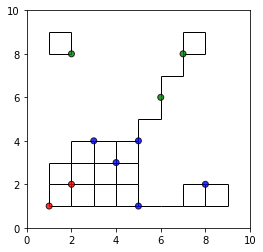

In [27]:
points = [[1, 1], [2, 2], [3, 4], [5, 1], [5, 4], [8, 2], [7, 8], [6,  6] , [2, 8], [4,3] ]

# k-means clustering
df, labels, centroids = make_clusters(3, points)
colmap = {1: 'r', 2: 'g', 3: 'b', 4: 'y', 5: 'k', 6: 'm'}
colors = list(map(lambda x: colmap[x+1], labels))

# landscape clustering
G = make_graph(40, 10, 0.8, points)
pos = dict( (n, n) for n in G.nodes() )

# make plots
fig, ax = plt.subplots(figsize=(4,4)); plt.xlim(0, 10); plt.ylim(0, 10);

nx.draw_networkx_edges(G, pos, ax = ax, with_labels = False)
plt.scatter(df['x'], df['y'], c = colors, alpha=0.8, edgecolor='k')

In [28]:
L0 = 25; Npts = 120; 
points2 = np.random.randint(L0 - 2, size=(Npts, 2)) + 1

number of original edges 1104
number of final edges 423


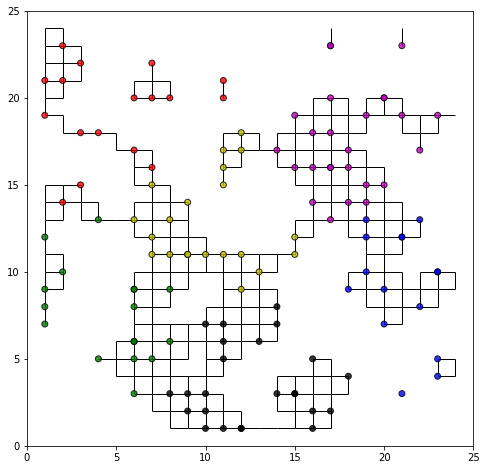

In [30]:
kcluster = 6; alpha_cutoff = 0.7;

# k-means clustering
df, labels, centroids = make_clusters(kcluster, points2)
colmap = {1: 'r', 2: 'g', 3: 'b', 4: 'y', 5: 'k', 6: 'm'}
colors = list(map(lambda x: colmap[x+1], labels))

# landscape clustering
G = make_graph(60, L0, alpha_cutoff, points2)
pos = dict((n, n) for n in G.nodes() )

# make plots
fig, ax = plt.subplots(figsize=(8,8)); plt.xlim(0, L0); plt.ylim(0, L0);

nx.draw_networkx_edges(G, pos, ax = ax, with_labels = False)
plt.scatter(df['x'], df['y'], c = colors, alpha = 0.8, edgecolor='k')

advantages of landscape vs k-means:

- takes care of edges, ensuring that each cluste is always connected

- takes into account 'local density', so it naturally avoids holes. This can be alleviated in k-means by adding more clusters, but then we have to combine the clusters by some other means

guidelines:

- at high density, take alpha_cutoff small

things to try:

- add/remove edges with the mouse? 

# Steiner tree

## Example 1

In [31]:
points = [(1, 1), (2, 2), (3, 4), (5, 1), (5, 4), (8, 2), (7, 8), (6,  6), (2,8), (4,3) ]

In [32]:
G = nx.grid_2d_graph(range(1,int(10)), range(1,int(10))) 

The number of edges of the Steiner tree is 26


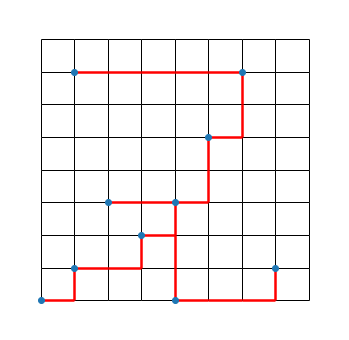

In [33]:
make_naive_steiner_plot(G, L = 10, points = points)

number of original edges 144
number of final edges 52
The total number of edges of the Steiner trees is 21


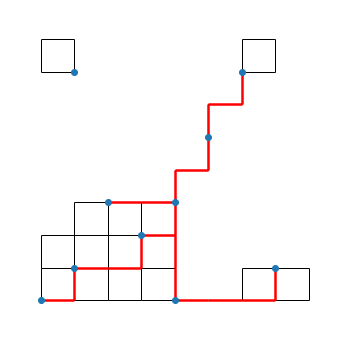

In [34]:
make_improved_steiner_plot(G, 10, 0.8, points)

## Example 2

In [34]:
L = 40
points2 = [(np.random.randint(L-2) + 1, np.random.randint(L-2) + 1) for i in range(250) ]
G = nx.grid_2d_graph(range(1,int(L)), range(1,int(L))) 

The number of edges of the Steiner tree is 472


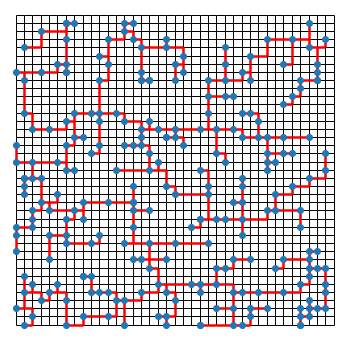

In [35]:
make_naive_steiner_plot(G, L, points = points2)

number of original edges 2964
number of final edges 1287
The total number of edges of the Steiner trees is 424


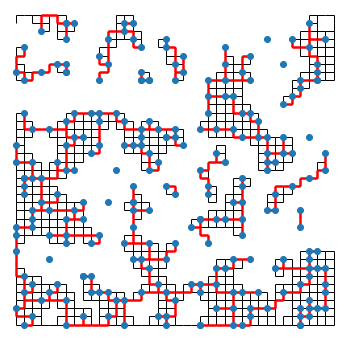

In [37]:
make_improved_steiner_plot(G, L, 1.5, points2)